In [1]:
import os
import pandas as pd
import glob

import sys; sys.path.insert(0, "./utils/")
from data_utils import get_data_location, get_clinical_df, get_bluepoints_df
from ml_pipeline import highlight_max
from statistics import evaluate_logits

DATA_PATH = get_data_location()
print("Infered Data path:", DATA_PATH)

Infered Data path: /itet-stor/mrichte/covlus_bmicnas02/


## Load Clinical & Bluepoint Data

In [ ]:
clinical_data = get_clinical_df()

clinical_data = clinical_data[["Video ID", "clin_diagn#COVID19_pneumonia"]]
clinical_data.columns = ["Patient ID", "COVID19"]

bp = get_bluepoints_df()

df = pd.merge(bp, clinical_data, on="Patient ID").sort_values(by=["Patient ID", "Bluepoint"])
# Reorder columns
df = df[["Patient ID", "Bluepoint", "video_name", "COVID19"]]
df.head()

#### Add manual severity labels

In [ ]:
manual_severity_score_path = os.path.join(DATA_PATH,"severity_scores.xlsx")

# Read the excel sheets of both tablets
tablets_dict_df = pd.read_excel(manual_severity_score_path, sheet_name=["Tablet A", "Tablet C"] )
tablet_A = tablets_dict_df.get("Tablet A")
tablet_C = tablets_dict_df.get("Tablet C")

tablet_A["Tablet"] = "A"
tablet_C["Tablet"] = "C"

# Drop all unnamed columns
tablet_A = tablet_A.loc[:, ~tablet_A.columns.str.contains('^Unnamed')]
tablet_C = tablet_C.loc[:, ~tablet_C.columns.str.contains('^Unnamed')]

# Change columns of tablet C to make them uniform
tablet_C.rename(columns={"comment": "comments"}, inplace=True)

# Combine the two dataframes
severity_manual = pd.concat([tablet_A, tablet_C], axis=0)
# Keep only columns with KEEP == YES
severity_manual = severity_manual[severity_manual["KEEP"] == "YES"]
# Print number of discarded rows
print("Number of discarded rows:", len(tablet_A) + len(tablet_C) - len(severity_manual))
# Drop file extension from video ID
severity_manual["video_name"] = severity_manual["Video ID"].str.replace(".mp4", "")
# Drop video ID, Patient ID, KEEP
severity_manual = severity_manual.drop(columns=["Video ID", "Patient ID", "KEEP"])
severity_manual.head(1)

In [ ]:
# Merge with clinical & bp df
severity = pd.merge(severity_manual, df, on=["video_name"]).sort_values(by=["Patient ID", "Bluepoint"]).reset_index(drop=True)
# Reorder columns
severity = severity[["Patient ID", 
                    "Bluepoint", 
                    "video_name", 
                    "COVID19", 
                    "Tablet", 
                    "Severity Score", 
                    "A-lines",
                    "B-lines",
                    "comments", 
                    ]]
# Rename for convenience
severity.rename(columns={"Severity Score": "Severity"}, inplace=True)

# Drop rows with missing severity scores
severity = severity[~severity["Severity"].isna()]
severity.head()

### Severity Score analysis

In [5]:
# Statistical test to check whether the COVID cases have on average different severity scores
from scipy import stats as st
from scipy.stats import mannwhitneyu
from scipy.stats import spearmanr

x0 = severity[severity["COVID19"] == 0]["Severity"]
x1 = severity[severity["COVID19"] == 1]["Severity"]

# T-Test for independent samples
ttest = st.ttest_ind(a=x0, b=x1, equal_var=True)
print(f"T-Test: statistic={ttest.statistic:.4f}, p-value={ttest.pvalue:.4f}")

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

T-Test: statistic=-0.3054, p-value=0.7602
Mann–Whitney U Test: statistic=16118.5000, p-value=0.8884
No significant difference


On the video level there is no significant difference in the severity score distribution between the Covid + and - groups.

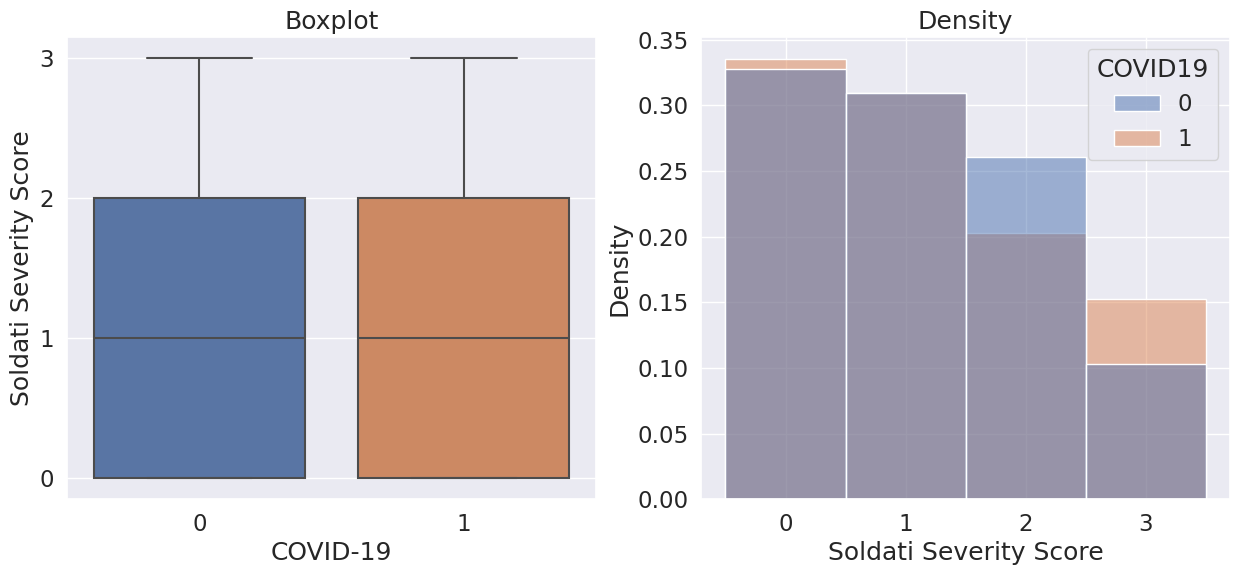

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
#set seaborn plotting aesthetics as default
sns.set(font_scale=1.5)
#define plotting region 
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#Create different views of the severity score against the COVID19 diagnosis
# sns.boxplot(data=severity, x='COVID19', y='Severity', ax=axes[0,0]).set(title='Boxplot')
# sns.histplot(data=severity, x='Severity', hue='COVID19', bins=4, ax=axes[0,1]).set(title='Histogram')
# sns.histplot(data=severity, x='Severity', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1,0]).set(title='Density')
# sns.kdeplot(x='Severity', data=severity, hue='COVID19', common_norm=False, ax=axes[1,1]).set(title='KDE')
# plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

#Create boxplot and density plot views of the severity score against the COVID19 diagnosis
sns.boxplot(data=severity, x='COVID19', y='Severity', ax=axes[0]).set(title='Boxplot', xlabel='COVID-19', ylabel='Soldati Severity Score')
axes[0].set_yticks([0, 1, 2, 3])
sns.histplot(data=severity, x='Severity', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1], discrete=True).set(title='Density', xlabel='Soldati Severity Score', ylabel='Density')
plt.show()

The plots confirm that visually there does not seem to be a separation between the two groups.

In [7]:
# Correlate covid with severity score
corr = severity.Severity.corr(severity.COVID19)
print(f"Correlation between severity score and COVID19 diagnosis: {corr:.4f}")

from scipy.stats import spearmanr

#Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(severity['Severity'], severity['COVID19'])
print(f"Spearman Rank correlation: rho={rho:.4f}, p-value={p:.4f}")


Correlation between severity score and COVID19 diagnosis: 0.0161
Spearman Rank correlation: rho=0.0074, p-value=0.8882


Correlation is also very low.

#### Patient level severity analysis

In [8]:

severity_patient_grp = severity.groupby("Patient ID")

severity_mean = severity_patient_grp.Severity.mean().rename("Severity_mean")
severtiy_sum = severity_patient_grp.Severity.sum().rename("Severity_sum")
severity_max = severity_patient_grp.Severity.max().rename("Severity_max")
severity_std = severity_patient_grp.Severity.std().rename("Severity_std")
covid = severity_patient_grp.COVID19.first()
accumulation_df = pd.concat([severity_mean, severtiy_sum, severity_max, severity_std, covid], axis=1)
# Drop nan values. 1 in std and spearman can't deal with it.
accumulation_df_dropped_nan = accumulation_df.dropna()

# Correlate COVID column with all other columns (aggregation_strategies) in accumulation_df
corr = severity.Severity.corr(severity.COVID19)
corr_mean = accumulation_df.COVID19.corr(accumulation_df.Severity_mean)
corr_sum = accumulation_df.COVID19.corr(accumulation_df.Severity_sum)
corr_max = accumulation_df.COVID19.corr(accumulation_df.Severity_max)
corr_std = accumulation_df_dropped_nan.COVID19.corr(accumulation_df_dropped_nan.Severity_std)

# Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(severity['Severity'], severity['COVID19'])
rho_mean, p_mean = spearmanr(accumulation_df['Severity_mean'], accumulation_df['COVID19'])
rho_sum, p_sum = spearmanr(accumulation_df['Severity_sum'], accumulation_df['COVID19'])
rho_max, p_max = spearmanr(accumulation_df['Severity_max'], accumulation_df['COVID19'])

rho_std, p_std = spearmanr(accumulation_df_dropped_nan['Severity_std'], accumulation_df_dropped_nan['COVID19'])

# Perform Mann-Witney U-Test for all aggregation strategies
stat, p_value = mannwhitneyu(severity[severity["COVID19"] == 0]["Severity"], severity[severity["COVID19"] == 1]["Severity"])
stat_mean, p_value_mean = mannwhitneyu(accumulation_df[accumulation_df["COVID19"] == 0]["Severity_mean"], accumulation_df[accumulation_df["COVID19"] == 1]["Severity_mean"])
stat_sum, p_value_sum = mannwhitneyu(accumulation_df[accumulation_df["COVID19"] == 0]["Severity_sum"], accumulation_df[accumulation_df["COVID19"] == 1]["Severity_sum"])
stat_max, p_value_max = mannwhitneyu(accumulation_df[accumulation_df["COVID19"] == 0]["Severity_max"], accumulation_df[accumulation_df["COVID19"] == 1]["Severity_max"])
stat_std, p_value_std = mannwhitneyu(accumulation_df_dropped_nan[accumulation_df_dropped_nan["COVID19"] == 0]["Severity_std"], accumulation_df_dropped_nan[accumulation_df_dropped_nan["COVID19"] == 1]["Severity_std"])


# Put all into a df
corr_df = pd.DataFrame({"Correlation": [corr, corr_mean, corr_sum, corr_max, corr_std],
                        "Spearman Rank correlation": [rho, rho_mean, rho_sum, rho_max, rho_std],
                        },
                          index=["Severity", "Severity_mean", "Severity_sum", "Severity_max", "Severity_std"])

# Put all into a df
stats_df = pd.DataFrame({
                        "Mann-Whitney U-Test p-value": [p_value, p_value_mean, p_value_sum, p_value_max, p_value_std],
                        "Significant": [p_value < 0.05, p_value_mean < 0.05, p_value_sum < 0.05, p_value_max < 0.05, p_value_std < 0.05],
                        },
                          index=["Severity", "Severity_mean", "Severity_sum", "Severity_max", "Severity_std"])
print(stats_df)
corr_df.style.apply(highlight_max).format("{:.2f}")


               Mann-Whitney U-Test p-value  Significant
Severity                          0.888357        False
Severity_mean                     0.653995        False
Severity_sum                      0.575897        False
Severity_max                      0.703980        False
Severity_std                      0.596100        False


,Correlation,Spearman Rank correlation
Severity,0.02,0.01
Severity_mean,0.06,0.06
Severity_sum,0.09,0.07
Severity_max,0.03,0.05
Severity_std,0.05,0.07


### Evaluate predictive performance of severity score for COVID19

In [9]:
# Evaluate the logits of the YOLONet
gt = severity["COVID19"].values
predictions = (severity["Severity"] >= 1).astype(int).values

eval = evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
eval = pd.concat([eval], keys=["None"], names=['Accumulation'])
eval.style.format("{:.2f}")

The values without patient level accumulation don't look very promising

Next try to accumulate the severity scores by different means and check the patient-level performance.

To do so we calculate get the optimal cut-off value for all aggregation strategies and evaluate the results.

In [10]:
# Trying to find optimal threshold values for all accumulation scores
import numpy as np
from sklearn.metrics import roc_curve, auc

# Taken from https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


In [11]:
from sklearn.model_selection import train_test_split
eval_acc = eval
accumulation_columns = list(accumulation_df_dropped_nan.columns[accumulation_df_dropped_nan.columns.str.contains("Severity")])
gt = accumulation_df_dropped_nan["COVID19"]
for acc in accumulation_columns:
    X = accumulation_df_dropped_nan[acc]
    y = gt
    # Split into train and test to determine optimal cutoff on train set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    # Find optimal probability threshold
    threshold = Find_Optimal_Cutoff(y_train, X_train)[0]
    print(f"Threshold for {acc}: {threshold}")
    # Get prediction by applying threshold to the test set
    predictions = X_test.map(lambda x: 1 if x > threshold else 0)
    temp = evaluate_logits(y_test, predictions, CLASSES=["No COVID", "COVID"])
    temp = pd.concat([temp], keys=[acc], names=['Accumulation'])
    eval_acc = pd.concat([eval_acc, temp])

eval_acc.style.apply(highlight_max).format("{:.2f}")

Threshold for Severity_mean: 1.0
Threshold for Severity_sum: 6.0
Threshold for Severity_max: 3.0
Threshold for Severity_std: 0.816496580927726


/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch_net/gnarf/mrichte/conda_envs/DL4LUS/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [12]:
# print(eval_acc.to_latex())

This does not improve the results significantly.

### Does the variance in severity scores differ from covid vs non-covid?

Mann–Whitney U Test: statistic=440.5000, p-value=0.5961
No significant difference


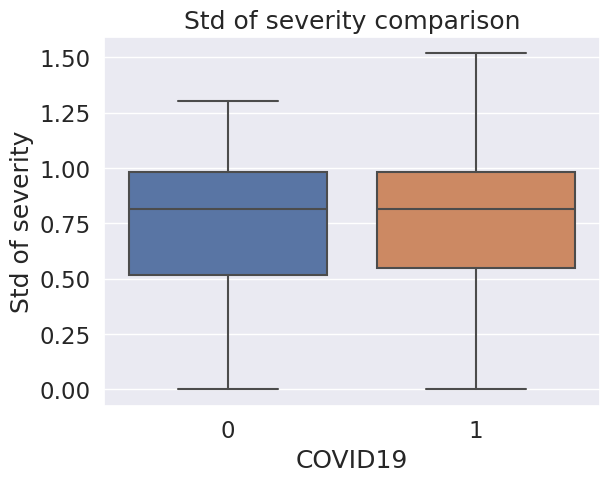

In [13]:
severity_variance = severity.groupby("Patient ID").agg({"Severity": "std","COVID19": "first"}).reset_index()
severity_variance = severity_variance.rename(columns={"Severity": "Severity_std"})
severity_variance = severity_variance.dropna()

# Get the severity variance for COVID and non-COVID patients
x0 = severity_variance[severity_variance["COVID19"] == 0]["Severity_std"].values
x1 = severity_variance[severity_variance["COVID19"] == 1]["Severity_std"].values
# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(x0, x1)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

# Print green if p-value is significant otherwise red
if p_value < 0.05:
    print("\033[92mSignificant difference\033[0m")
else:
    print("\033[91mNo significant difference\033[0m")

sns.boxplot(data=severity_variance, x='COVID19', y='Severity_std').set(title='Std of severity comparison')
# Set y axis label
plt.ylabel("Std of severity")
plt.show()

## Bluepoint level severity analysis

In [14]:
bluepoints = severity.Bluepoint.unique()
bluepoints = bluepoints[bluepoints != "None"]
bluepoints = [x for x in bluepoints if str(x) != 'nan']
# bluepoints.sort()
bluepoints

['L1', 'L2', 'L3', 'R1', 'R2', 'R3']

Bluepoint L1 has 65 frames
Bluepoint L2 has 56 frames
Bluepoint L3 has 56 frames
Bluepoint R1 has 64 frames
Bluepoint R2 has 61 frames
Bluepoint R3 has 59 frames


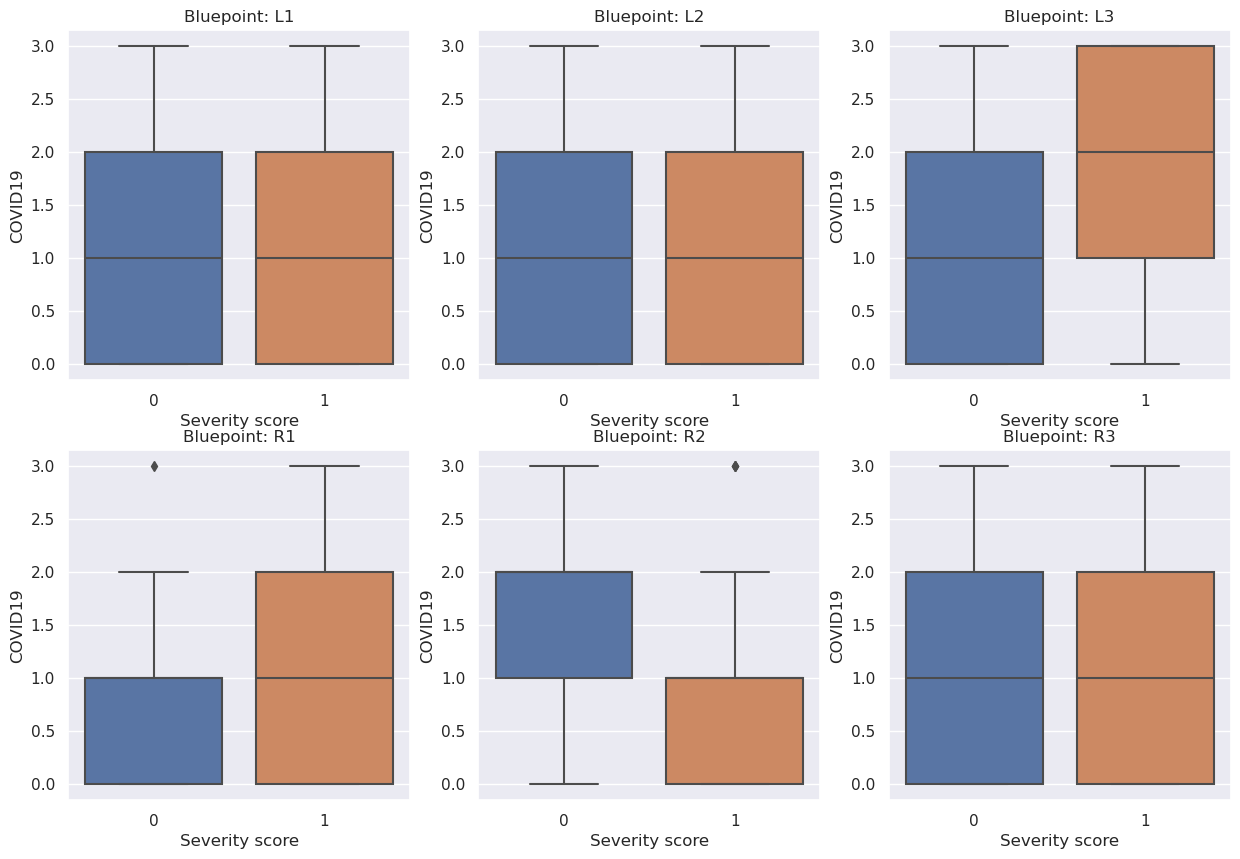

In [15]:
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = severity[severity.Bluepoint == bp]
    # Plot the data
    print(f"Bluepoint {bp} has {bp_df.shape[0]} frames")
    sns.boxplot(data=bp_df, x="COVID19", y="Severity", ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("Severity score")
    axes[i//3, i%3].set_ylabel("COVID19")
    
plt.show()

Try Violinplot instead

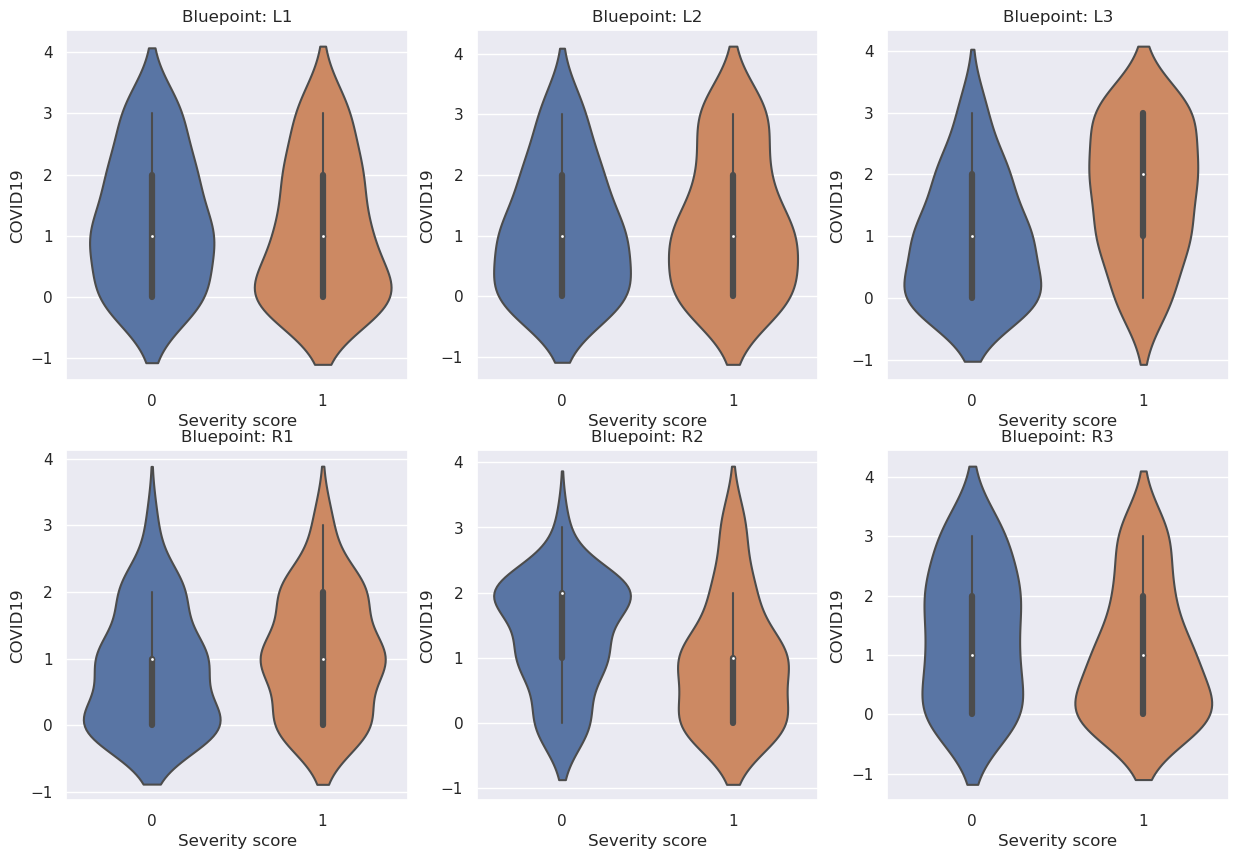

In [16]:
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = severity[severity.Bluepoint == bp]
    # Plot the data
    sns.violinplot(data=bp_df, x="COVID19", y="Severity", ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("Severity score")
    axes[i//3, i%3].set_ylabel("COVID19")
    
plt.show()

In [17]:
for bp in bluepoints:
    if bp == "None":
        continue
    corr_cov = severity[severity.Bluepoint == bp].Severity.corr(severity[severity.Bluepoint == bp].COVID19)
    print(f"Bluepoint: {bp}\tCorr: {corr_cov:.2f}")

Bluepoint: L1	Corr: -0.08
Bluepoint: L2	Corr: 0.07
Bluepoint: L3	Corr: 0.35
Bluepoint: R1	Corr: 0.14
Bluepoint: R2	Corr: -0.23
Bluepoint: R3	Corr: -0.14


Its a somewhat inverted picture as compared to the YOLO and the Segmentation results. No clear trend in the Bluepoints.

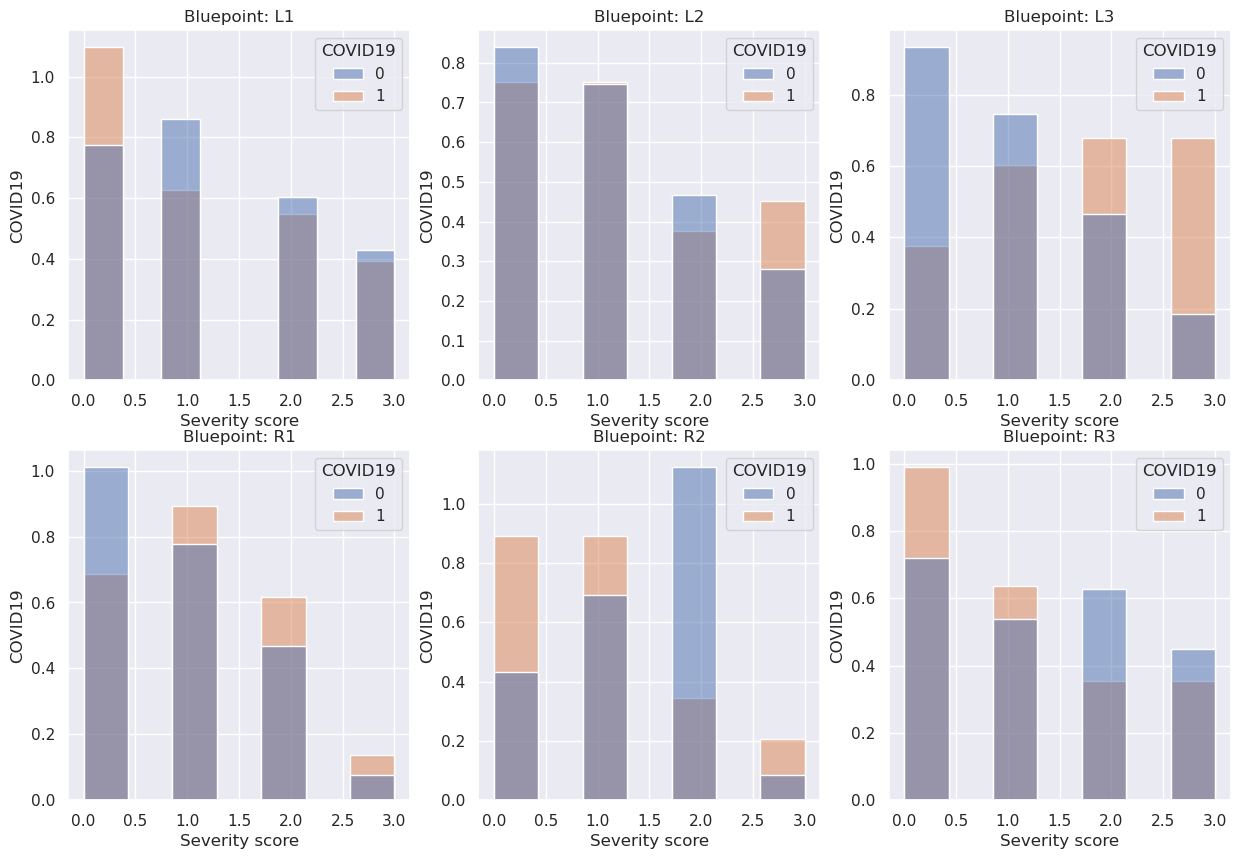

In [18]:
#set seaborn plotting aesthetics as default
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, bp in enumerate(bluepoints):
    # Filter the data
    bp_df = severity[severity.Bluepoint == bp]
    # Plot the data
    sns.histplot(data=bp_df, x="Severity", hue="COVID19", stat='density', common_norm=False, ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f"Bluepoint: {bp}")
    axes[i//3, i%3].set_xlabel("Severity score")
    axes[i//3, i%3].set_ylabel("COVID19")
    
plt.show()

The density plot shows the same picture. A lot better separation along the severiy score. 

Inspired by this result check the predictive performance of the severity score per bluepoint.

In [19]:
# Evaluate the logits of the YOLONet for all bluepoints
gt = severity["COVID19"].values
predictions = (severity["Severity"] >= 1).astype(int).values

eval = evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
eval = pd.concat([eval], keys=["All"], names=['Bluepoint'])

In [20]:
eval_bp = eval
for bp in bluepoints:
    if bp == "None": continue
    bp_df = severity[severity.Bluepoint == bp]
    gt = bp_df["COVID19"].values
    predictions = (bp_df["Severity"] >= 1).astype(int).values
    temp = evaluate_logits(gt, predictions, CLASSES=["No COVID", "COVID"])
    temp = pd.concat([temp], keys=[bp], names=['Bluepoint'])
    eval_bp = pd.concat([eval_bp, temp])

eval_bp.style.background_gradient().apply(highlight_max)

In [21]:
# latex = eval_bp.drop(columns=["specificity", "precision", "recall", "accuracy", "f1-score", "mcc"])
# print(latex.reset_index().drop(columns=["level_1"]).drop_duplicates().rename(columns={"balanced": "Balanced Accuracy"}).to_latex(index=False, float_format="%.2f"))

L3 seems to be over all the best performing bp. LR2 are consistently bad.

### Blue point analysis on manual severity labels

In [22]:
bp_left = severity[severity.Bluepoint.isin(["L1", "L2", "L3"])].Severity
bp_right = severity[severity.Bluepoint.isin(["R1", "R2", "R3"])].Severity

bp_1 = severity[severity.Bluepoint.isin(["L1", "R1"])].Severity
bp_2 = severity[severity.Bluepoint.isin(["L2", "R2"])].Severity
bp_3 = severity[severity.Bluepoint.isin(["L3", "R3"])].Severity

p_values = []

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(bp_left, bp_right)
p_values.append(p_value)
print("Bluepoint left vs right")
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print(f"Mean severity left: {bp_left.mean():.4f}")
print(f"Mean severity right: {bp_right.mean():.4f}")

print("")
print("Bluepoint 1 vs 2 vs 3")
print("1 vs 2")
stat, p_value = mannwhitneyu(bp_1, bp_2)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("2 vs 3")
stat, p_value = mannwhitneyu(bp_2, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")
print("1 vs 3")
stat, p_value = mannwhitneyu(bp_1, bp_3)
p_values.append(p_value)
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

print("\nMeans:")
print(f"Mean severity 1: {bp_1.mean():.4f}")
print(f"Mean severity 2: {bp_2.mean():.4f}")
print(f"Mean severity 3: {bp_3.mean():.4f}")

Bluepoint left vs right
Mann–Whitney U Test: statistic=17361.5000, p-value=0.2572
Mean severity left: 1.2316
Mean severity right: 1.0870

Bluepoint 1 vs 2 vs 3
1 vs 2
Mann–Whitney U Test: statistic=7214.0000, p-value=0.5332
2 vs 3
Mann–Whitney U Test: statistic=6358.5000, p-value=0.4533
1 vs 3
Mann–Whitney U Test: statistic=6711.0000, p-value=0.1813

Means:
Mean severity 1: 1.0698
Mean severity 2: 1.1453
Mean severity 3: 1.2696


In [23]:
# Using bonferonni correction for multiple comparisons
from statsmodels.sandbox.stats.multicomp import multipletests
p_adjusted = multipletests(p_values, method='bonferroni')

print("Bonferroni corrected p-values:")
print(f"L vs R: {p_adjusted[1][0]:.3f}. Significant: {p_adjusted[0][0]}")
print(f"1 vs 2: {p_adjusted[1][1]:.3f}. Significant: {p_adjusted[0][1]}")
print(f"2 vs 3: {p_adjusted[1][2]:.3f}. Significant: {p_adjusted[0][2]}")
print(f"1 vs 3: {p_adjusted[1][3]:.3f}. Significant: {p_adjusted[0][3]}")

Bonferroni corrected p-values:
L vs R: 1.000. Significant: False
1 vs 2: 1.000. Significant: False
2 vs 3: 1.000. Significant: False
1 vs 3: 0.725. Significant: False


Statistical test validates that there is no significant trend in the bluepoint distributions.

### Compare POCOVID scores

In [25]:
# Load pocovid severity scores

pocovid_metadata_path = os.path.join(DATA_PATH, "additional_datasets/POCOVID/dataset_metadata.csv")
pocovid = pd.read_csv(pocovid_metadata_path)

In [26]:
pocovid = pocovid[["Label", "Lung Severity Score"]]
pocovid = pocovid.rename(columns={"Lung Severity Score": "Severity"})
pocovid["COVID19"] = pocovid.Label.apply(lambda x: 1 if x == "COVID-19" else 0)

In [27]:
pocovid_no_nan = pocovid.dropna()
pocovid_no_nan

,Label,Severity,COVID19
2,COVID-19,2.0,1
4,regular,0.0,0
5,COVID-19,2.0,1
7,COVID-19,3.0,1
8,COVID-19,3.0,1
...,...,...,...
295,COVID-19,1.0,1
296,COVID-19,1.0,1
297,COVID-19,1.0,1
298,COVID-19,1.0,1


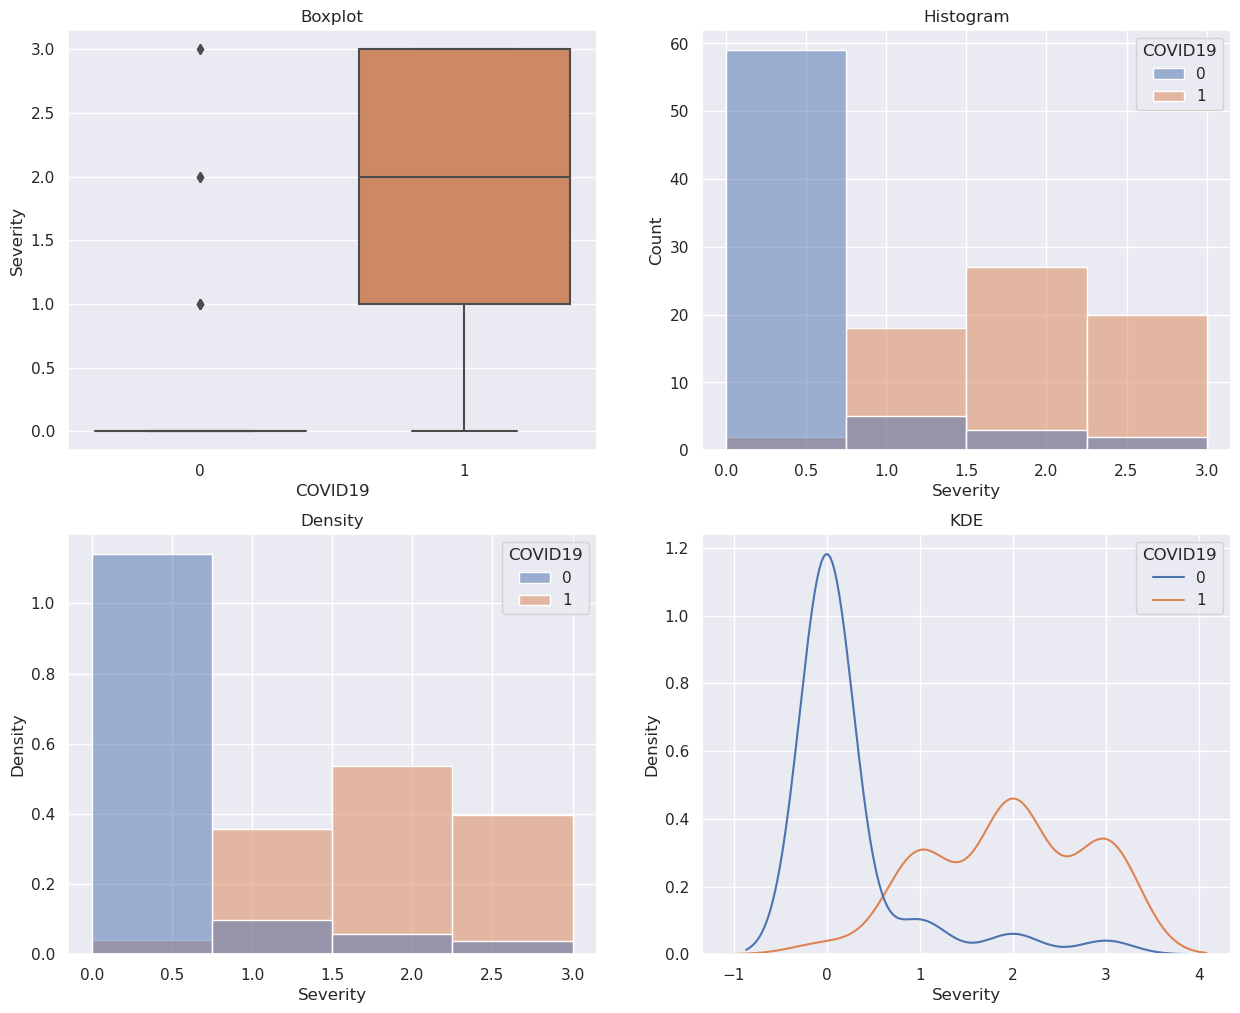

In [28]:
sns.set()
#define plotting region 
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#Create different views of the severity score against the COVID19 diagnosis
sns.boxplot(data=pocovid_no_nan, x='COVID19', y='Severity', ax=axes[0,0]).set(title='Boxplot')
sns.histplot(data=pocovid_no_nan, x='Severity', hue='COVID19', bins=4, ax=axes[0,1]).set(title='Histogram')
sns.histplot(data=pocovid_no_nan, x='Severity', hue='COVID19', bins=4, stat='density', common_norm=False, ax=axes[1,0]).set(title='Density')
sns.kdeplot(x='Severity', data=pocovid_no_nan, hue='COVID19', common_norm=False, ax=axes[1,1]).set(title='KDE')
plt.show()

In [29]:
#Calculate Spearman Rank correlation and corresponding p-value
rho, p = spearmanr(pocovid_no_nan['Severity'], pocovid_no_nan['COVID19'])
print(f"Spearman Rank correlation: rho={rho:.4f}, p-value={p:.4f}")

Spearman Rank correlation: rho=0.7875, p-value=0.0000


In [30]:
# Mean of severity score for COVID19 patients
print("Mean severity score for COVID19 patients in the POCOVID ds: ", pocovid_no_nan[pocovid_no_nan["COVID19"] == 1]["Severity"].mean())
print("Mean severity score for COVID19 patients in the MAASTRICHT ds: ", severity[severity["COVID19"] == 1]["Severity"].mean())

# Mann-Whitney U-Test
stat, p_value = mannwhitneyu(pocovid_no_nan[pocovid_no_nan["COVID19"] == 1]["Severity"], severity[severity["COVID19"] == 1]["Severity"])
print(f"Mann–Whitney U Test: statistic={stat:.4f}, p-value={p_value:.4f}")

Mean severity score for COVID19 patients in the POCOVID ds:  1.9701492537313432
Mean severity score for COVID19 patients in the MAASTRICHT ds:  1.1725888324873097
Mann–Whitney U Test: statistic=9412.0000, p-value=0.0000


## How do the manual severity scores relate other clinical variables?

Hypotheses:
#### Factors increasing severity score
- Severity score is higher in patients with more severe symptoms
    - ICU admission (Not supported, more patients without covid on ICU than with covid, higher mean severity score for patients not in ICU)
    - Oxygen saturation (Hypothesis supported. $R^2=-0.17, p=0.002$)
    - Respiratory rate (Hypothesis supported. $R^2=0.12, p=0.024$)
    - Temperature (Not supported, $R^2=-0.07$)
    - Length of stay (Weakly supported, not significant, $R^2=0.09, p=0.092$)
    
#### Factors decreasing severity score
- Severity is lower for patients with a vaccination. (Weakly supported, $R^2=-0.11$, not significant $p=0.19$)
- Non pathological vital parameters
    - Severity score is lower for patients with clin_diagn#healthy_lung (Not supported, $R^2=0.02$)

#### Other questions
- Does the severity score correlate with the severity score of the other lung? (Yes $R^2=0.22. P-value=0.007$)
- The severity score changes over time. Less severe cases in the summer/later in the pandemic
    - Different variants, higher population immunity, summer heat, etc.
    - Yes but only slightly (R^2=-0.16. P-value=0.002 all videos, R^2=-0.22. P-value=0.081 patient mean). I don't think this is significant enough to be of interest.

QUESTION: 
- Do the analysis for the entire dataset or only for the patients with COVID19 diagnosis?
- Vaccination variable has values 0, 1, 2. What does 2 mean? Assuming >0 -> Vaccinted (perhaps partially vaccinated)

In [31]:
clinical_data = get_clinical_df()
print(clinical_data.columns)

Index(['Castor ID', 'Video ID', 'Number of video files', 'Video path',
       'Participant Id', 'Participant Creation Date', 'pat_ID', 'adm_date',
       'incl_crit#fever_or_chills', 'incl_crit#cough',
       ...
       'oxygen_other_appl_2', 'start_oxy_2', 'end_oxy_2', 'duration_oxy_2',
       'add_remarks', 'pos_bp', 'sys_bp', 'dias_bp', 'datetime_bp',
       'report_date_bp'],
      dtype='object', length=216)


In [32]:
# # input_data.at[ind_val, 'oxygen_saturation_with_ox'] = 91.0        #Change '90-92' to 91 
# input_data.at[55, 'body_temperature'] = 36.6                        #Change '36,6' to 36.6
# input_data.at[8, 'CRP'] = 0.5                                       #Change '<1' to 0.5
# input_data.at[26, 'CRP'] = 0.5                                      #Change '<1' to 0.5
# input_data.at[60, 'body_temperature'] = 37.1                        #Change 7.1 to 37.1

# input_data = input_data.astype(float)                               #Turn all values into floats

In [33]:
#Filter -99 and make it nan
clinical_data = clinical_data.reset_index().drop('index', axis=1)
for col in clinical_data.columns:
    for ind_val, val in enumerate(clinical_data[col]): 
        if val == (-99.0 or '-99.0'):
            clinical_data.at[ind_val, col] = np.nan
        

In [34]:
import scipy.stats as stats

def kruskal_test(data, column):
    # Hypothesis test: is the column significantly different for patients within differen severity score group?
    sev_0 = data[data['Severity'] == 0][column]
    sev_1 = data[data['Severity'] == 1][column]
    sev_2 = data[data['Severity'] == 2][column]
    sev_3 = data[data['Severity'] == 3][column] 
    # Perform the Kruskal-Wallis test. The Kruskal-Wallis test is a non-parametric test for multiple groups. It is used when the data is not normally distributed.
    h_stat, p_val = stats.kruskal(sev_0, sev_1, sev_2, sev_3)
    print(f"Kruskal-Wallis test: H-statistic: {h_stat:.2f}, p-value: {p_val:.2f}")


### JONCKHEERE-TERPSTRSA would be the right test for us but there is no python implementation

### ICU Stay

How many patients (videos) with ICU stay had Covid?
0    37
1    27
Name: COVID19, dtype: int64

Severity mean against ICU stay:
stay_icu
False    1.228188
True     0.828125
Name: Severity, dtype: float64
Mean severity score for COVID19 patients in the ICU:  0.7037037037037037
Mean severity score for healthy patients in the ICU:  0.918918918918919
Mean severity score for COVID19 patients in the ICU:  0.7037037037037037
Mean severity score for COVID19 patients not in the ICU:  1.2470588235294118


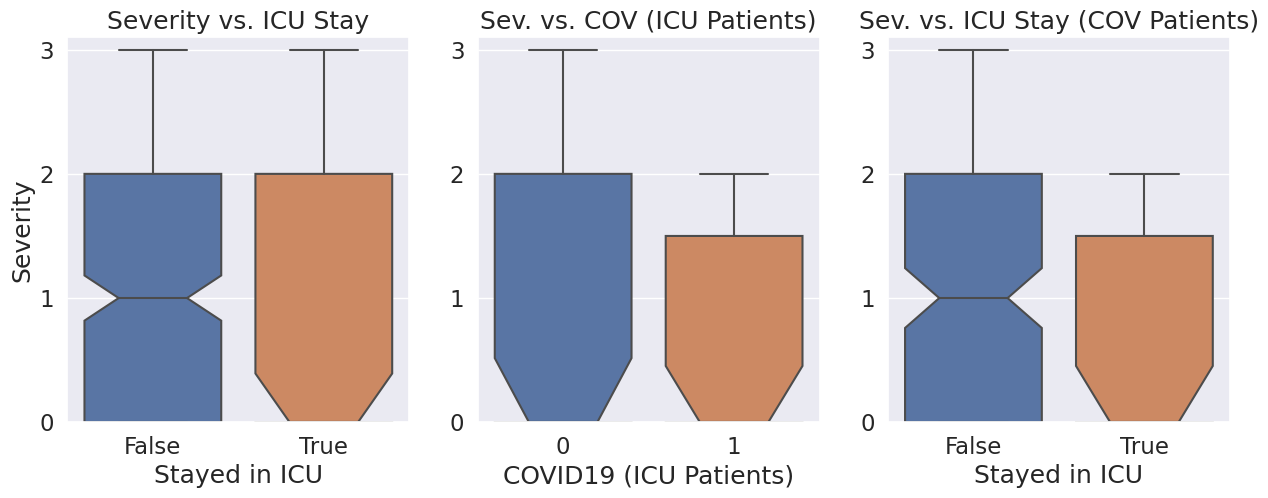

In [35]:
stay_icu = clinical_data[["stay_icu", 'Video ID']].fillna(0)
# Transform stay_icu to 0/1
stay_icu['stay_icu'] = stay_icu['stay_icu'].apply(lambda x: True if x == 1 else False)
# Rename Video ID to Patient ID
stay_icu = stay_icu.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
stay_icu = severity.merge(stay_icu, on='Patient ID', how='left')
# Severity to int
stay_icu['Severity'] = stay_icu['Severity'].astype(int)

# Check how many patients with ICU stay had Covid
print("How many patients (videos) with ICU stay had Covid?")
print(stay_icu[stay_icu['stay_icu'] == 1]['COVID19'].value_counts())
print("\nSeverity mean against ICU stay:")
print(stay_icu.groupby('stay_icu')['Severity'].mean())

sns.set(font_scale=1.5)

# Three subplots checking the hypothesis
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# Plot severity against ICU stay
sns.boxplot(x='stay_icu', y='Severity', data=stay_icu, ax=ax1, notch=True)
# Subplot title
ax1.title.set_text('Severity vs. ICU Stay')
# Fix y axis range
ax1.set_ylim(0, 3.1)
# Set y ticks as integers
ax1.set_yticks([0, 1, 2, 3])
# Set x axis label
ax1.set_xlabel('Stayed in ICU')

# Check whether of all patients on the ICU the ones with COVID have a higher severity score
icu_patients = stay_icu[stay_icu['stay_icu'] == 1]
# Print mean severity score for COVID19 vs healthy patients in the ICU
print("Mean severity score for COVID19 patients in the ICU: ", icu_patients[icu_patients["COVID19"] == 1]["Severity"].mean())
print("Mean severity score for healthy patients in the ICU: ", icu_patients[icu_patients["COVID19"] == 0]["Severity"].mean())
# Plot severity against covid heatmap
sns.boxplot(x='COVID19', y='Severity', data=icu_patients, ax=ax2, notch=True)
ax2.title.set_text('Sev. vs. COV (ICU Patients)')
# Fix y axis range
ax2.set_ylim(0, 3.1)
# Set y ticks as integers
ax2.set_yticks([0, 1, 2, 3])
# Set x axis label
ax2.set_xlabel('COVID19 (ICU Patients)')
# Set y axis label
ax2.set_ylabel('')

covid = stay_icu[stay_icu['COVID19'] == 1]
# Print mean severity for COVID19 patients in the ICU vs COVID19 patients not in the ICU
print("Mean severity score for COVID19 patients in the ICU: ", covid[covid["stay_icu"] == 1]["Severity"].mean())
print("Mean severity score for COVID19 patients not in the ICU: ", covid[covid["stay_icu"] == 0]["Severity"].mean())
# Plot severity against ICU stay
sns.boxplot(x='stay_icu', y='Severity', data=covid, ax=ax3, notch=True)
ax3.title.set_text('Sev. vs. ICU Stay (COV Patients)')
# Fix y axis range
ax3.set_ylim(0, 3.1)
# Set y ticks as integers
ax3.set_yticks([0, 1, 2, 3])
# Set x axis label
ax3.set_xlabel('Stayed in ICU')
# Set y axis label
ax3.set_ylabel('')

plt.show()

More videos of patients in the ICU that did not have Covid.
The Severity mean is much higher for patients that were not administered to the ICU (Not ICU: 1.23, ICU: 0.8).
Of all patients in the ICU the severity scores are higher for the patients without covid.
Of all patients with Covid the severity scores are higher for the patients that were not administered to the ICU. 

Hypothesis not supported.

### Oxygen Saturation

Correlation between oxygen saturation and severity: R^2=-0.17. P-value=0.002


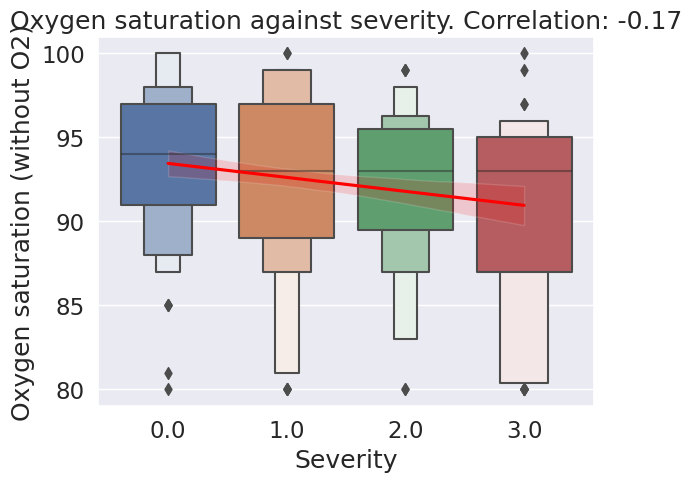

In [36]:
ox = clinical_data[["oxygen_saturation_without_ox", 'Video ID']].fillna(0)
# Rename Video ID to Patient ID
ox = ox.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
ox = severity.merge(ox, on='Patient ID', how='left')
# Drop rows with 0
ox = ox[ox['oxygen_saturation_without_ox'] != 0]

# Correlate with Severity
corr, p = stats.pearsonr(ox['oxygen_saturation_without_ox'], ox['Severity'])
print(f"Correlation between oxygen saturation and severity: R^2={corr:.2f}. P-value={p:.3f}")
# Plot correlation
sns.boxenplot(y='oxygen_saturation_without_ox', x='Severity', data=ox)
plt.title(f'Oxygen saturation against severity. Correlation: {corr:.2f}')
# Add regreession line
sns.regplot(y='oxygen_saturation_without_ox', x='Severity', data=ox, scatter=False, color='red')
# Set y and x labels
plt.ylabel('Oxygen saturation (without O2)')
plt.xlabel('Severity')
plt.show()

Slight negative trend indicating that a higher Severity score is associated with a lower oxygen saturation. Hypothesis supported. (R^2=-0.17)

### Respiratory Rate

Correlation between respiratory rate and severity: R^2=0.12. P-value=0.024


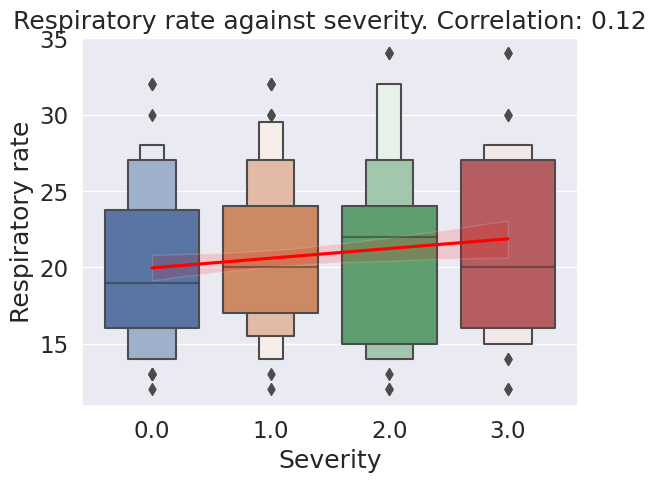

In [37]:
resp = clinical_data[["respiratory_rate", 'Video ID']].fillna(0)
# Rename Video ID to Patient ID
resp = resp.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
resp = severity.merge(resp, on='Patient ID', how='left')

# Drop rows with 0
resp = resp[resp['respiratory_rate'] != 0]

# Correlate with Severity
corr, p = stats.pearsonr(resp['respiratory_rate'], resp['Severity'])
print(f"Correlation between respiratory rate and severity: R^2={corr:.2f}. P-value={p:.3f}")
# Plot correlation
sns.boxenplot(y='respiratory_rate', x='Severity', data=resp)
plt.title(f'Respiratory rate against severity. Correlation: {corr:.2f}')
# Add regreession line
sns.regplot(y='respiratory_rate', x='Severity', data=resp, scatter=False, color='red')
# Set y and x labels
plt.ylabel('Respiratory rate')
plt.xlabel('Severity')

plt.show()

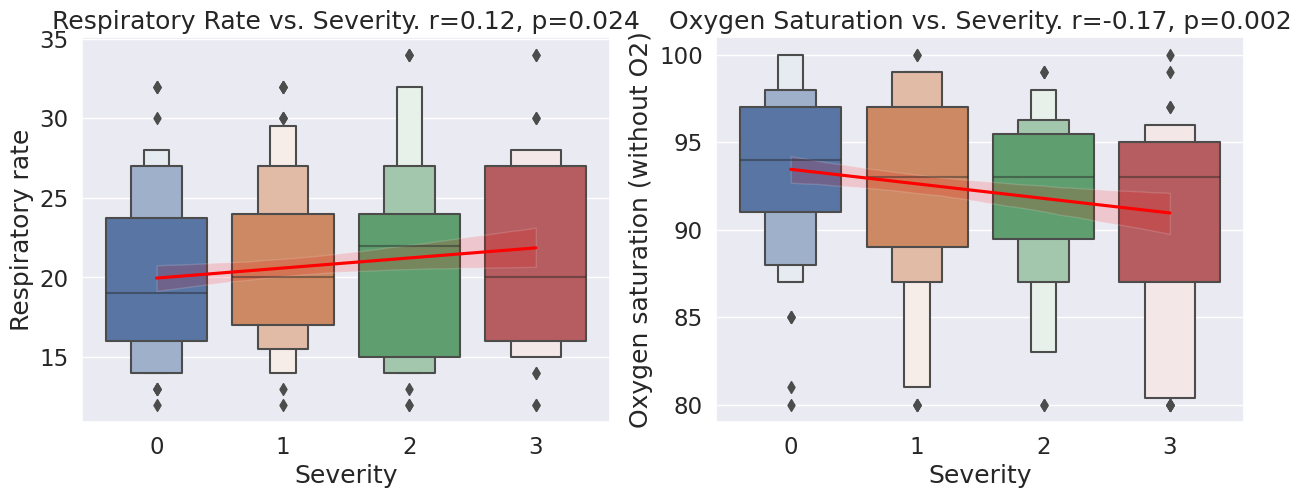

In [38]:
# Severity to int
resp["Severity"] = resp["Severity"].astype(int)
ox["Severity"] = ox["Severity"].astype(int)

sns.set(font_scale=1.5)
# Combine respiratory rate and oxygen saturation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
# Plot respiratory rate
sns.boxenplot(y='respiratory_rate', x='Severity', data=resp, ax=ax1)
corr, p = stats.pearsonr(resp['respiratory_rate'], resp['Severity'])
ax1.title.set_text(f'Respiratory Rate vs. Severity. r={corr:.2f}, p={p:.3f}')
# Add regreession line
sns.regplot(y='respiratory_rate', x='Severity', data=resp, scatter=False, color='red', ax=ax1)
# Set y and x labels
ax1.set_ylabel('Respiratory rate')
ax1.set_xlabel('Severity')

# Plot oxygen saturation
sns.boxenplot(y='oxygen_saturation_without_ox', x='Severity', data=ox, ax=ax2)
corr, p = stats.pearsonr(ox['oxygen_saturation_without_ox'], ox['Severity'])
ax2.title.set_text(f'Oxygen Saturation vs. Severity. r={corr:.2f}, p={p:.3f}')
# Add regreession line
sns.regplot(y='oxygen_saturation_without_ox', x='Severity', data=ox, scatter=False, color='red', ax=ax2)
# Set y and x labels
ax2.set_ylabel('Oxygen saturation (without O2)')
ax2.set_xlabel('Severity')

plt.show()

In [39]:
# Correlate oxygen saturation with respiratory rate
# Merge ox and resp
ox_resp = ox.merge(resp, on='Patient ID', how='left')
# Drop rows with nan in either oxygen saturation or respiratory rate
ox_resp = ox_resp.dropna(subset=['oxygen_saturation_without_ox', 'respiratory_rate'])
# Correlate
corr, p = stats.pearsonr(ox_resp['oxygen_saturation_without_ox'], ox_resp['respiratory_rate'])
print(f"Correlation between oxygen saturation and respiratory rate: R^2={corr:.2f}. P-value={p:.3f}")

Correlation between oxygen saturation and respiratory rate: R^2=-0.26. P-value=0.000


We take a higher respiratory rate to be indicative of a pathological lung. We can see that the severity score is higher for patients with a higher respiratory rate. Hypothesis supported. (R^2=0.12)

CAVEAT: We also have very low respiratory rates in the dataset (<10). This could also be indicative of a pathology.

Correlation of the oxygen saturation and the respiratory rate is low (R^2=-0.26). This is expected as a higher respiratory rate indicates a lower oxygen saturation and supports our approach of using the respiratory rate as a proxy for a pathological lung.

### Temperature

Correlation between body temperature and severity: R^2=-0.07. P-value=0.197


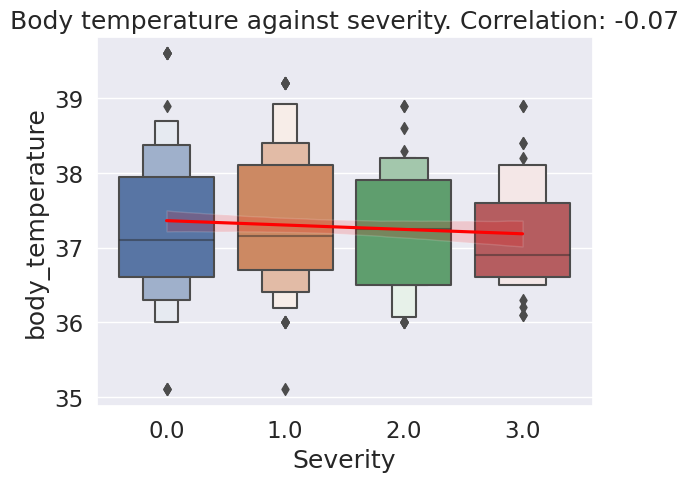

In [40]:
temp = clinical_data[["body_temperature", 'Video ID']]
# Rename Video ID to Patient ID
temp = temp.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
temp = severity.merge(temp, on='Patient ID', how='left')

temp["body_temperature"].mask(temp["body_temperature"] == '-99', np.nan, inplace=True)
temp["body_temperature"].mask(temp["body_temperature"] == '7.1', '37.1', inplace=True)
# Replace , with .
temp["body_temperature"] = temp["body_temperature"].str.replace(',', '.')
temp["body_temperature"] = temp["body_temperature"].astype(float)
# Drop rows where body_temperature is nan
temp = temp.dropna(subset=['body_temperature'])

# Correlate with Severity
corr, p = stats.pearsonr(temp['body_temperature'], temp['Severity'])
print(f"Correlation between body temperature and severity: R^2={corr:.2f}. P-value={p:.3f}")
# Plot correlation
sns.boxenplot(y='body_temperature', x='Severity', data=temp)
plt.title(f'Body temperature against severity. Correlation: {corr:.2f}')
# Add regreession line
sns.regplot(y='body_temperature', x='Severity', data=temp, scatter=False, color='red')
plt.show()

The temperature is very slightly negatively correlated (-0.07) with the severity score. This does not support our hypothesis that a higher severity score correlates with a higher body temperature (fever).

### Length of stay

Correlation between stay and severity: R^2=0.09. P-value=0.092


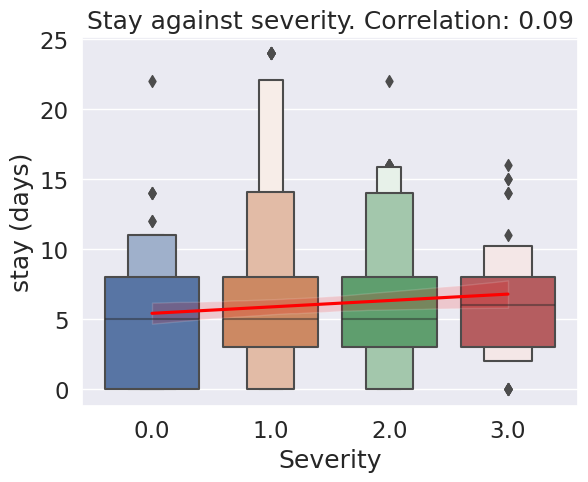

In [41]:
stay = clinical_data[["adm_date", "dis_date", 'Video ID']]
# Rename Video ID to Patient ID
stay = stay.rename(columns={'Video ID': 'Patient ID'})
# Transform to datetime. The format is DD-MM-YYYY
stay['adm_date'] = pd.to_datetime(stay['adm_date'], format='%d-%m-%Y')
stay['dis_date'] = pd.to_datetime(stay['dis_date'], format='%d-%m-%Y')
# Calculate stay
stay['stay'] = stay['dis_date'] - stay['adm_date']
# Drop adm_date and dis_date
stay = stay.drop(columns=['adm_date', 'dis_date'])
stay
# Transform stay to int(days)
stay['stay (days)'] = stay['stay'].dt.days

# Merge with severity
stay = severity.merge(stay, on='Patient ID', how='left')

# Correlate with Severity
corr, p = stats.pearsonr(stay['stay (days)'], stay['Severity'])
print(f"Correlation between stay and severity: R^2={corr:.2f}. P-value={p:.3f}")
# Plot correlation
sns.boxenplot(y='stay (days)', x='Severity', data=stay)
plt.title(f'Stay against severity. Correlation: {corr:.2f}')
# Add regreession line
sns.regplot(y='stay (days)', x='Severity', data=stay, scatter=False, color='red')
plt.show()

The severity score is positively correlated with the length of stay (R^2=0.09). This supports our hypothesis that a higher severity score correlates with a longer length of stay.

### Vaccination Status

Patients with info available vs not available:
0    50
1    13
Name: avail_data#Covid19_vaccination_info, dtype: int64
Patients with info available. Original vacc data:
Patients with info available. Vaccinated vs not vaccinated:
Correlation between vaccination and severity: R^2=-0.11. P-value=0.369
Mean severity for vaccinated vs not vaccinated:
C19_vacc
0    1.571429
1    1.307692
Name: Severity, dtype: float64
Mann-Whitney U test: U statistic: 475.50. P-value: 0.19


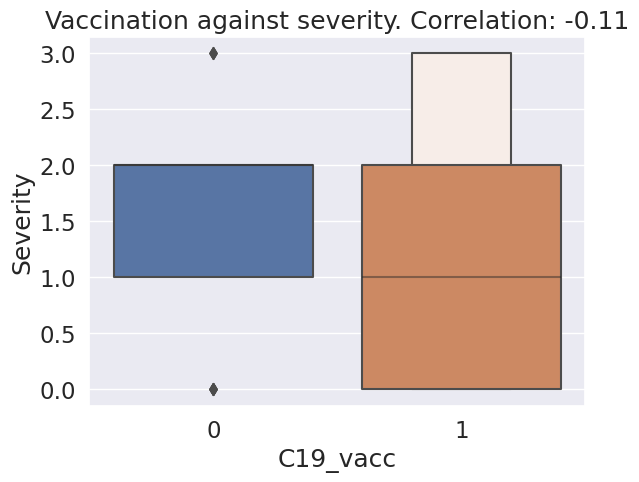

In [42]:
vacc_colums = [#'vacc_date', #Too many nans, default value should be inf, bc 0 means they where vacc that day
                'C19_vacc', #Mostly nans
                'avail_data#Covid19_vaccination_info']

vacc = clinical_data[vacc_colums + ['Video ID']]
# Rename Video ID to Patient ID
vacc = vacc.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
vacc = severity.merge(vacc, on='Patient ID', how='left')

# Print number of info available vs not available
print("Patients with info available vs not available:")
print(vacc.groupby("Patient ID").first()['avail_data#Covid19_vaccination_info'].value_counts())

# Keep only rows with vacc info available
vacc = vacc[vacc['avail_data#Covid19_vaccination_info'] == 1]
# Drop avail_data#Covid19_vaccination_info
vacc = vacc.drop(columns=['avail_data#Covid19_vaccination_info'])

print("Patients with info available. Original vacc data:")
vacc["C19_vacc"].value_counts()
# What does 0,1,2 correspond to? 
# The"study_variablelist.csv" specifies: C19_vacc	Yes/No/Partially    Yes = last dose 2 weeks before SEH admission date

# Assuming >0 means vaccinated
vacc["C19_vacc"] = vacc["C19_vacc"].apply(lambda x: 1 if x > 0 else 0)
print("Patients with info available. Vaccinated vs not vaccinated:")
vacc["C19_vacc"].value_counts()

# Correlate with Severity
corr, p = stats.pearsonr(vacc['C19_vacc'], vacc['Severity'])
print(f"Correlation between vaccination and severity: R^2={corr:.2f}. P-value={p:.3f}")

print("Mean severity for vaccinated vs not vaccinated:")
print(vacc.groupby("C19_vacc").mean()['Severity'])
# Plot heatmap
# sns.heatmap(pd.crosstab(vacc['C19_vacc'], vacc['Severity']), annot=True, fmt='d')
# plt.title(f'Vaccination against severity. Correlation: {corr:.2f}')
# Plot correlation
sns.boxenplot(x='C19_vacc', y='Severity', data=vacc)
plt.title(f'Vaccination against severity. Correlation: {corr:.2f}')

# Hypothesis test: is the severity score distribution for vaccinated patients significantly lower than for unvaccinated patiens?
# Null hypothesis: the severity score distribution for vaccinated patients is not significantly lower than for unvaccinated patiens
# Alternative hypothesis: the severity score distribution for vaccinated patients is significantly lower than for unvaccinated patiens

# Get severity scores for vaccinated and unvaccinated patients
vacc_severity = vacc[vacc['C19_vacc'] == 1]['Severity']
unvacc_severity = vacc[vacc['C19_vacc'] == 0]['Severity']
# Mann-Whitney U test
u, p = mannwhitneyu(vacc_severity, unvacc_severity, alternative='less')
print(f'Mann-Whitney U test: U statistic: {u:.2f}. P-value: {p:.2f}')

plt.show()


Slightly higher mean sev for unvaccinated patients (vacc = 1.3, unvacc = 1.6). Slight negative correlation (-0.11). Hypothesis supported.
Not significant!
CAVEAT: Only very few Patients (13) have vaccination data available. Not very strong analysis.

### Healthy lung

Correlation between healthy lung and severity: R^2=0.02. P-value=0.690
Mean severity for healthy lung vs not healthy lung:
clin_diagn#healthy_lung
0    1.148026
1    1.206897
Name: Severity, dtype: float64


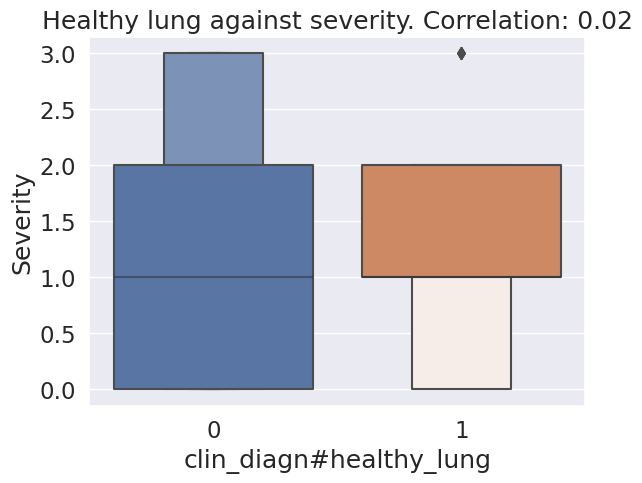

In [43]:
# Test is Severity score is lower for patients with clin_diagn#healthy_lung
healthy_lung = clinical_data[["clin_diagn#healthy_lung", 'Video ID']]
# Rename Video ID to Patient ID
healthy_lung = healthy_lung.rename(columns={'Video ID': 'Patient ID'})
# Merge with severity
healthy_lung = severity.merge(healthy_lung, on='Patient ID', how='left')

# Correlate with Severity
corr, p = stats.pearsonr(healthy_lung['clin_diagn#healthy_lung'], healthy_lung['Severity'])
print(f"Correlation between healthy lung and severity: R^2={corr:.2f}. P-value={p:.3f}")
print("Mean severity for healthy lung vs not healthy lung:")
print(healthy_lung.groupby("clin_diagn#healthy_lung").mean()['Severity'])
# Plot correlation
sns.boxenplot(x='clin_diagn#healthy_lung', y='Severity', data=healthy_lung)
plt.title(f'Healthy lung against severity. Correlation: {corr:.2f}')
plt.show()

Higher mean severity scores for patients with a healthy lung (healthy_lung = 1.2, non_healthy_lung = 1.1). Very sublte positive correlation (0.02). Hypothesis not supported.

### Lung Symmetry

Correlation between L1 and R1: R^2=0.36. P-value=0.012
Correlation between L2 and R2: R^2=0.21. P-value=0.157
Correlation between L3 and R3: R^2=0.12. P-value=0.419


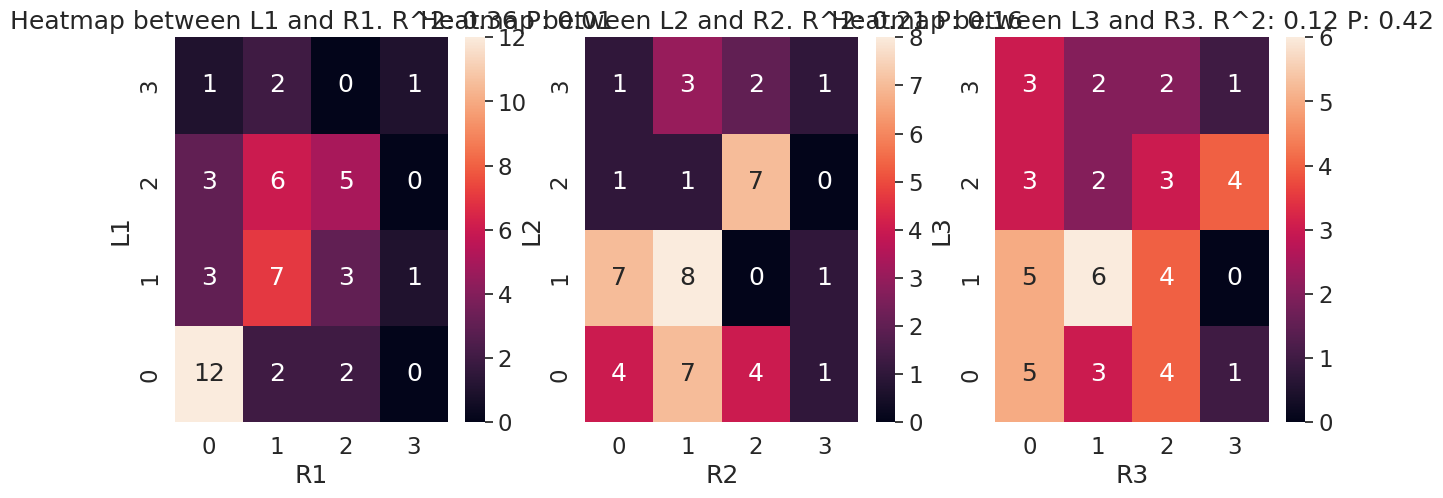

In [44]:
#Does the severity score correlate with the severity score of the other lung?
# Assigning L1 and R1 to the bilateral bluepoint "1", L2 and R2 to "2" and L3 and R3 to "3" for aggregated plotting
BP_symmetry = severity.copy()
# Drop rows with BP not in [L1, L2, L3, R1, R2, R3]
BP_symmetry = BP_symmetry[BP_symmetry['Bluepoint'].isin(['L1', 'L2', 'L3', 'R1', 'R2', 'R3'])]
BP_symmetry["Bluepoint_LR"] = BP_symmetry["Bluepoint"].apply(lambda x: x[0])
BP_symmetry["Bluepoint_No"] = BP_symmetry["Bluepoint"].apply(lambda x: x[1])
BP_symmetry

# Pivot the table such that there is a column each bluepoint. The values are the severity score. 
BP_symmetry = BP_symmetry.pivot_table(index='Patient ID', columns='Bluepoint', values='Severity')
# Drop rows which dont have all 6 bluepoints
BP_symmetry = BP_symmetry.dropna()
# Convert all values to int
BP_symmetry = BP_symmetry.astype(int)


# FOr each Bluepoint (1,2,3) correlate the severity score of the left lung with the severity score of the right lung and plot heatmap
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(1,4):
    corr, p = stats.pearsonr(BP_symmetry[f'L{i}'], BP_symmetry[f'R{i}'])
    print(f"Correlation between L{i} and R{i}: R^2={corr:.2f}. P-value={p:.3f}")
    sns.heatmap(pd.crosstab(BP_symmetry[f'L{i}'], BP_symmetry[f'R{i}']), annot=True, fmt='d', ax=axs[i-1])
    axs[i-1].set_title(f"Heatmap between L{i} and R{i}. R^2: {corr:.2f} P: {p:.2f}")
    axs[i-1].invert_yaxis()
    # Add regression line
    #sns.regplot(x=BP_symmetry[f'L{i}'], y=BP_symmetry[f'R{i}'], ax=axs[i-1])
plt.show()

Correlation between severity left lung and severity right lung: R^2=0.22. P-value=0.007
Wilcoxon rank test for paired samples: W statistic: 1534.00. P-value: 0.25


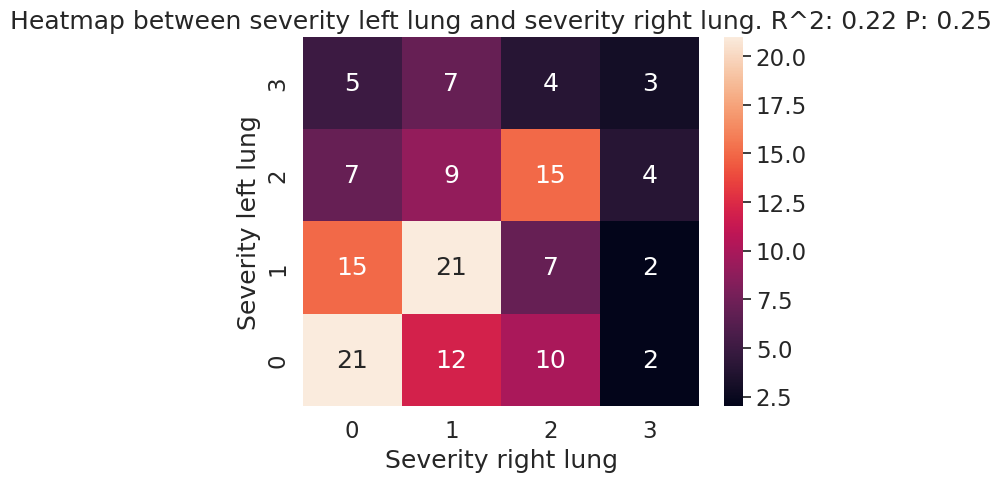

In [45]:
LR1 = BP_symmetry[['L1', 'R1']].rename(columns={'L1': 'L', 'R1': 'R'})
LR2 = BP_symmetry[['L2', 'R2']].rename(columns={'L2': 'L', 'R2': 'R'})
LR3 = BP_symmetry[['L3', 'R3']].rename(columns={'L3': 'L', 'R3': 'R'})

LR1["Bluepoint"] = "1"
LR2["Bluepoint"] = "2"
LR3["Bluepoint"] = "3"

# Concat the dataframes such that there is a column for the left and right lung containing all Bluepoints
LR = pd.concat([LR1, LR2, LR3], axis=0)
# Rename L and R to severity score
LR = LR.rename(columns={'L': 'Severity left lung', 'R': 'Severity right lung'})

# Correlation between the severity score of the left and right lung
corr, p = stats.pearsonr(LR['Severity left lung'], LR['Severity right lung'])
print(f"Correlation between severity left lung and severity right lung: R^2={corr:.2f}. P-value={p:.3f}")
# Wilkoxen rank test for paired samples
w, p = stats.wilcoxon(LR['Severity left lung'], LR['Severity right lung'])
print(f"Wilcoxon rank test for paired samples: W statistic: {w:.2f}. P-value: {p:.2f}")
# Plot correlation as heatmap
ax = sns.heatmap(pd.crosstab(LR['Severity left lung'], LR['Severity right lung']), annot=True, fmt='d')
ax.invert_yaxis()
plt.title(f"Heatmap between severity left lung and severity right lung. R^2: {corr:.2f} P: {p:.2f}")
plt.show()

Generally there is a correlation in severity score between the left and the right lung (R^2=0.22 P-value=0.007). This supports the validity of the scores.

### Evolving severity score over time

Correlation between admission date and severity score: R^2=-0.16. P-value=0.002


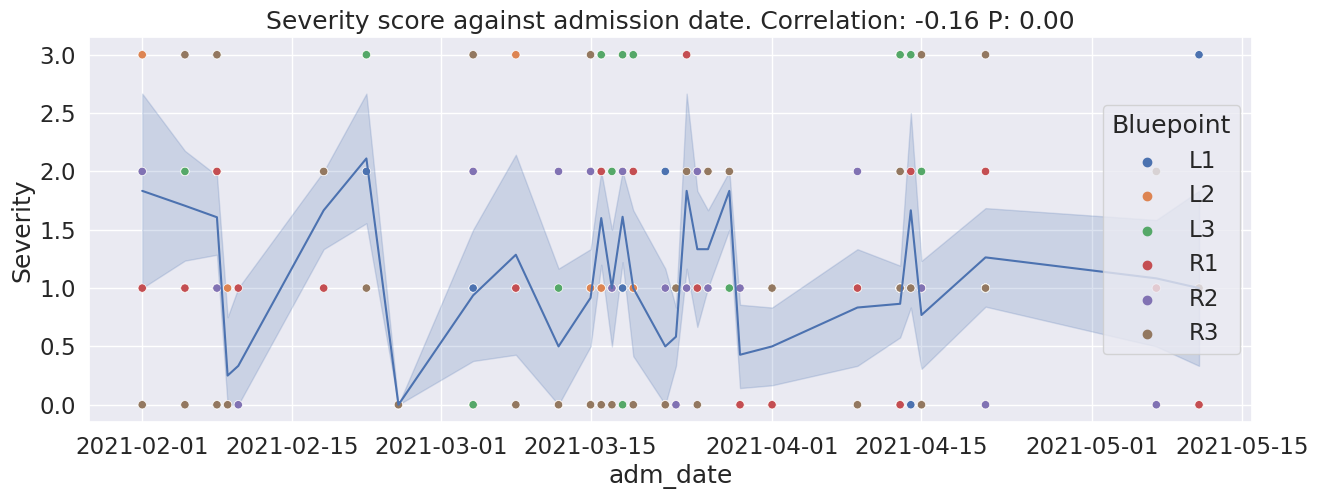

In [46]:
adm_date = clinical_data[["adm_date", 'Video ID']]
# Rename Video ID to Patient ID
adm_date = adm_date.rename(columns={'Video ID': 'Patient ID'})
# Transform to datetime. The format is DD-MM-YYYY
adm_date['adm_date'] = pd.to_datetime(adm_date['adm_date'], format='%d-%m-%Y')

# Merge with severity
adm_date = severity.merge(adm_date, on='Patient ID', how='left')

adm_date['adm_date'] = adm_date['adm_date'].apply(lambda x: x.date())

# Correlate severity score with admission date
corr, p = stats.pearsonr(adm_date['adm_date'].apply(lambda x: x.toordinal()), adm_date['Severity'])
print(f"Correlation between admission date and severity score: R^2={corr:.2f}. P-value={p:.3f}")

# Plot the severity score against the admission date
plt.figure(figsize=(15, 5))
sns.lineplot(x='adm_date', y='Severity', data=adm_date)
# Scatter on top
sns.scatterplot(x='adm_date', y='Severity', data=adm_date, hue="Bluepoint")
plt.title(f"Severity score against admission date. Correlation: {corr:.2f} P: {p:.2f}")
plt.show()

Visually there does not seem to be a clear trend in the data. There is a negative correlation though (R^2=-0.16. P-value=0.002) which could indicate that the disease severity gets lower towards the summer or towards the later stage of the pandemic as vaccination rate and general population immunity increases.

Correlation between admission date and severity score: R^2=-0.22. P-value=0.081


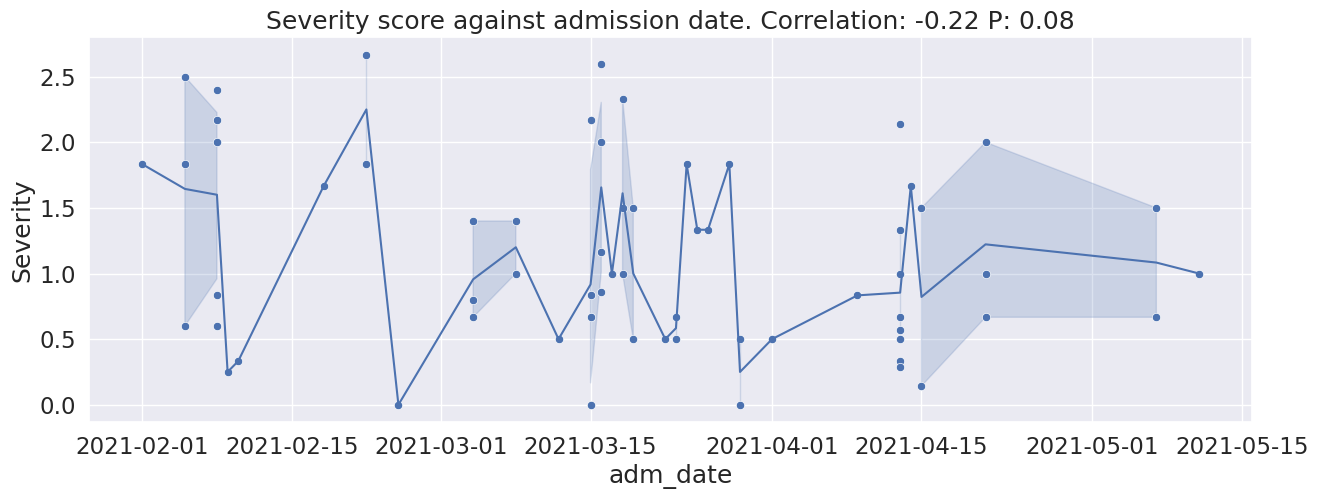

In [47]:
# Group by patient and get mean severity
adm_date_patient = adm_date.groupby('Patient ID').agg({'adm_date': 'first', 'Severity': 'mean'})
# Correlate severity score with admission date
corr, p = stats.pearsonr(adm_date_patient['adm_date'].apply(lambda x: x.toordinal()), adm_date_patient['Severity'])
print(f"Correlation between admission date and severity score: R^2={corr:.2f}. P-value={p:.3f}")

# Plot the severity score against the admission date
plt.figure(figsize=(15, 5))
sns.lineplot(x='adm_date', y='Severity', data=adm_date_patient)
# Scatter on top
sns.scatterplot(x='adm_date', y='Severity', data=adm_date_patient)
plt.title(f"Severity score against admission date. Correlation: {corr:.2f} P: {p:.2f}")
plt.show()

On patient level taking the mean of the severity score the correlation is a little stronger but not significant (R^2=-0.22. P-value=0.081).